In [3]:
# TensorFlow and tf.keras
import tensorflow as tf

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

2.4.1


In [6]:
#Check if GPU is available
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [7]:
# Parameters
BATCH_SIZE = 8
EPOCHS=30
IMG_SIZE = (224, 224)
LEARNING_RATE=0.001

##  Dataset Preparation

Split the dataset ....

In [9]:


CLASSES=["fabric", "foliage", "glass", "leather", "metal", "paper", "plastic", "stone", "water", "wood"]
IMAGE_DIR="../dataset/FMD/image"


train_dataset = tf.keras.preprocessing.image_dataset_from_directory(IMAGE_DIR,
                                                            class_names=CLASSES,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE,
                                                            seed=0,
                                                            validation_split=0.2,
                                                            subset="training",
                                                            interpolation='lanczos3',
                                                            #crop_to_aspect_ratio=True,
                                                           )
val_dataset = tf.keras.preprocessing.image_dataset_from_directory(  IMAGE_DIR,
                                                            class_names=CLASSES,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE,
                                                            seed=0,
                                                            validation_split=0.2,
                                                            subset="validation",
                                                            interpolation='lanczos3',
                                                            #crop_to_aspect_ratio=True,
                                                           )

Found 1000 files belonging to 10 classes.
Using 800 files for training.
Found 1000 files belonging to 10 classes.
Using 200 files for validation.


2021-11-03 02:51:17.764526: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-11-03 02:51:17.782682: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3099995000 Hz


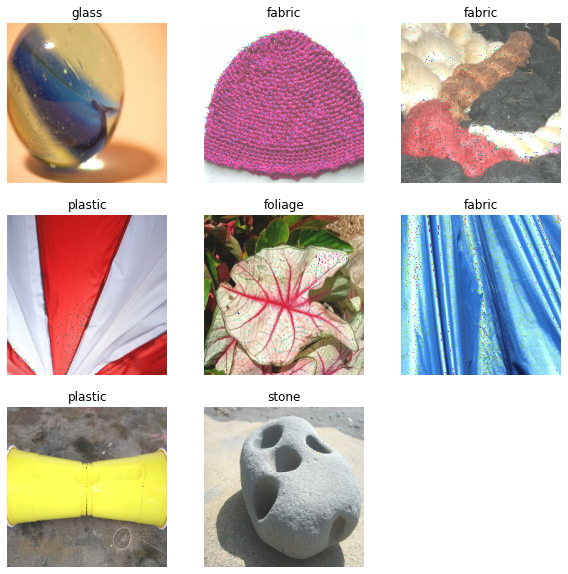

In [10]:
#visualize the dataset to ensure correctness
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(8):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [11]:
AUTOTUNE = tf.data.AUTOTUNE

# prefetch
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size=AUTOTUNE)


In [12]:
# data_augmentation = tf.keras.Sequential([
#   tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
#   tf.keras.layers.experimental.preprocessing.RandomRotation(0.5),
# ])
# tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(IMG_SIZE)),


(<tensorflow.python.keras.layers.preprocessing.image_preprocessing.Rescaling at 0x7f42d8277460>,)

## Model


In [17]:
base_model=tf.keras.applications.resnet50.ResNet50(
        include_top=False, weights='imagenet')
base_model.trainable=False


model = tf.keras.Sequential([
    tf.keras.layers.Lambda(tf.keras.applications.resnet.preprocess_input, name='preprocessing', input_shape=(224, 224, 3)),
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(10,activation="softmax")    
])


model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
preprocessing (Lambda)       (None, 224, 224, 3)       0         
_________________________________________________________________
resnet50 (Functional)        (None, None, None, 2048)  23587712  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                20490     
Total params: 23,608,202
Trainable params: 20,490
Non-trainable params: 23,587,712
_________________________________________________________________


In [18]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])


In [19]:
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint
EARLY_STOP_PATIENCE=10
early_stopper = EarlyStopping(monitor = 'val_loss', patience = EARLY_STOP_PATIENCE)
model_cp = ModelCheckpoint(filepath = './weights/baseline_best.hdf5', monitor = 'val_loss', save_best_only = True, mode = 'auto')

In [20]:
history = model.fit(
        train_dataset,
        epochs = EPOCHS,
        validation_data=val_dataset,
        callbacks=[model_cp, early_stopper]
)

Epoch 1/30
100/100 [==============================] - 5s 37ms/step - loss: 2.8035 - accuracy: 0.2796 - val_loss: 0.9062 - val_accuracy: 0.6950
Epoch 2/30
100/100 [==============================] - 3s 28ms/step - loss: 0.8991 - accuracy: 0.7025 - val_loss: 0.7333 - val_accuracy: 0.7800
Epoch 3/30
100/100 [==============================] - 3s 27ms/step - loss: 0.5925 - accuracy: 0.8172 - val_loss: 0.6439 - val_accuracy: 0.7900
Epoch 4/30
100/100 [==============================] - 3s 28ms/step - loss: 0.4477 - accuracy: 0.8323 - val_loss: 0.6142 - val_accuracy: 0.8100
Epoch 5/30
100/100 [==============================] - 3s 32ms/step - loss: 0.4053 - accuracy: 0.8777 - val_loss: 0.6431 - val_accuracy: 0.8100
Epoch 6/30
100/100 [==============================] - 3s 33ms/step - loss: 0.2393 - accuracy: 0.9113 - val_loss: 0.5935 - val_accuracy: 0.8200
Epoch 7/30
100/100 [==============================] - 3s 32ms/step - loss: 0.2096 - accuracy: 0.9410 - val_loss: 0.6165 - val_accuracy: 0.8250

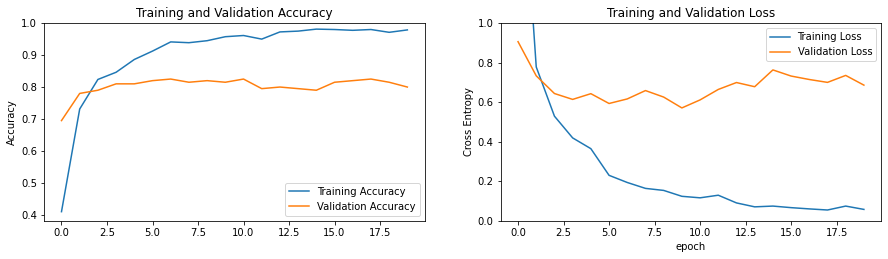

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(15, 8))
plt.subplot(2, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Fine Tuning 

In [22]:
base_model.trainable=True

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 150

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False


model.compile(optimizer=tf.keras.optimizers.Adam(LEARNING_RATE/10),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

model.summary()


Number of layers in the base model:  175
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
preprocessing (Lambda)       (None, 224, 224, 3)       0         
_________________________________________________________________
resnet50 (Functional)        (None, None, None, 2048)  23587712  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                20490     
Total params: 23,608,202
Trainable params: 10,010,634
Non-trainable params: 13,597,568
_________________________________________________________________


In [23]:
fine_tune_epochs = 10
initial_epochs=history.epoch[-1]
total_epochs = initial_epochs  + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=initial_epochs,
                         validation_data=val_dataset)

Epoch 20/29
100/100 [==============================] - 5s 33ms/step - loss: 0.3049 - accuracy: 0.8820 - val_loss: 1.0151 - val_accuracy: 0.8050
Epoch 21/29
100/100 [==============================] - 3s 28ms/step - loss: 0.2028 - accuracy: 0.9240 - val_loss: 0.8657 - val_accuracy: 0.8150
Epoch 22/29
100/100 [==============================] - 3s 28ms/step - loss: 0.1205 - accuracy: 0.9653 - val_loss: 0.8005 - val_accuracy: 0.7900
Epoch 23/29
100/100 [==============================] - 3s 28ms/step - loss: 0.0983 - accuracy: 0.9702 - val_loss: 0.8251 - val_accuracy: 0.7850
Epoch 24/29
100/100 [==============================] - 3s 28ms/step - loss: 0.0768 - accuracy: 0.9754 - val_loss: 0.9098 - val_accuracy: 0.8000
Epoch 25/29
100/100 [==============================] - 3s 28ms/step - loss: 0.0998 - accuracy: 0.9610 - val_loss: 0.8664 - val_accuracy: 0.8150
Epoch 26/29
100/100 [==============================] - 3s 28ms/step - loss: 0.0362 - accuracy: 0.9872 - val_loss: 0.7853 - val_accuracy:

In [24]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

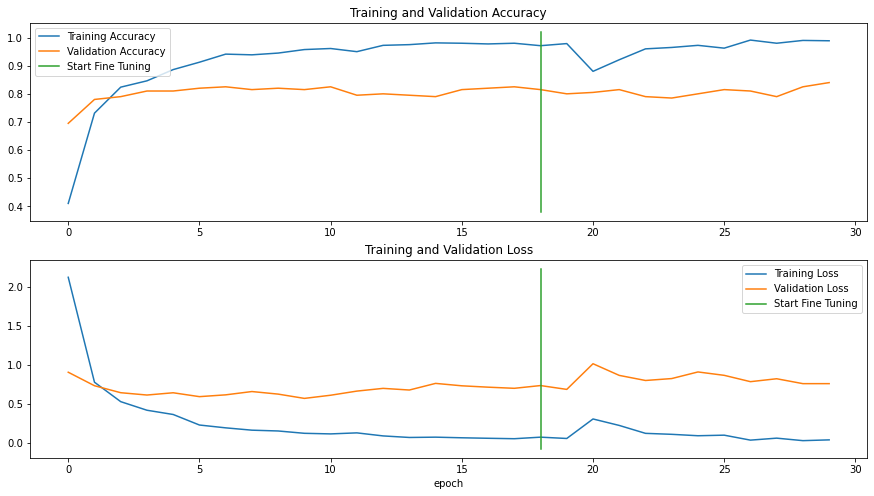

In [25]:
plt.figure(figsize=(15, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
# plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper left')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
# plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()